Downloading...
From (original): https://drive.google.com/uc?id=1aZYqdwk5dT4kSOStpVfUykmEqE4Pyuvd
From (redirected): https://drive.google.com/uc?id=1aZYqdwk5dT4kSOStpVfUykmEqE4Pyuvd&confirm=t&uuid=8d46c9a8-3cfe-4785-93ae-01e355d8e406
To: /content/cicids2017_cleaned.csv
100%|██████████| 717M/717M [00:11<00:00, 61.2MB/s]


File downloaded to: cicids2017_cleaned.csv

Loading and preprocessing data...
Dataset shape: (2520751, 52)
Number of features: 52
Target classes: ['Normal Traffic' 'Port Scanning' 'Web Attacks' 'Brute Force' 'DDoS'
 'Bots' 'DoS']
Target distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Fitting PCA...
Optimal number of components to explain 95.0% variance: 20


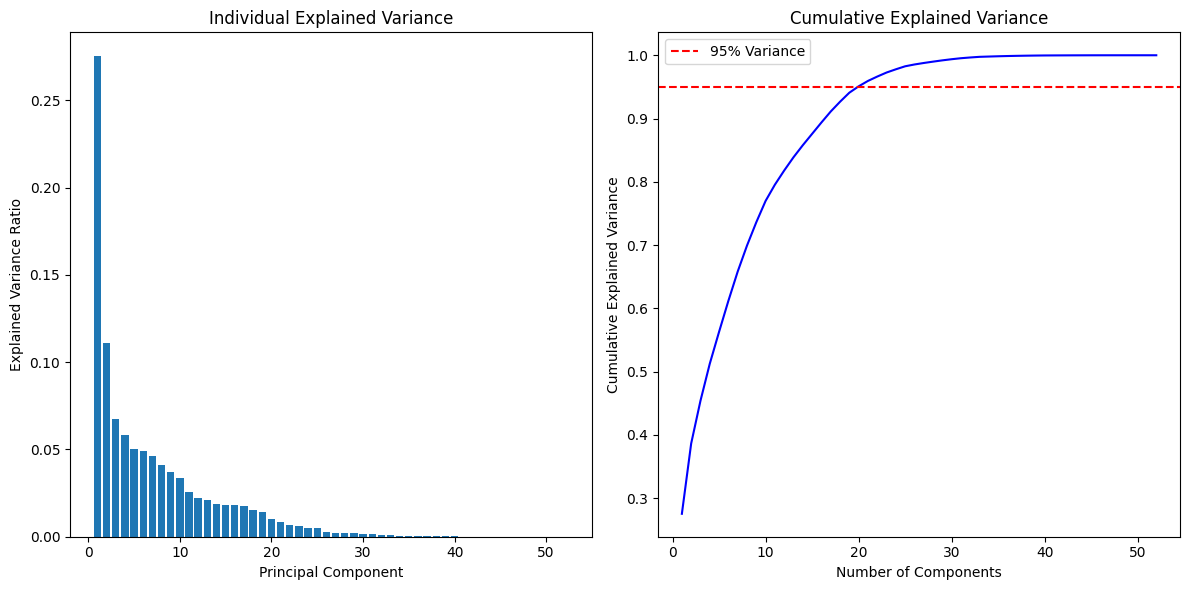


Top 15 Most Important Features:
                        Feature  Importance
32            Min Packet Length    0.154774
38               PSH Flag Count    0.150304
9         Bwd Packet Length Min    0.144673
41            Subflow Fwd Bytes    0.144076
3   Total Length of Fwd Packets    0.144001
23                Bwd IAT Total    0.132763
10       Bwd Packet Length Mean    0.129960
6        Fwd Packet Length Mean    0.126202
0              Destination Port    0.124723
47                   Active Max    0.124153
7         Fwd Packet Length Std    0.124147
40          Average Packet Size    0.123569
4         Fwd Packet Length Max    0.122527
11        Bwd Packet Length Std    0.121820
36       Packet Length Variance    0.121274

Top 15 Most Important Features:
                        Feature  Importance
32            Min Packet Length    0.154774
38               PSH Flag Count    0.150304
9         Bwd Packet Length Min    0.144673
41            Subflow Fwd Bytes    0.144076
3   Total 

/tmp/ipython-input-3658668617.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(n_features),


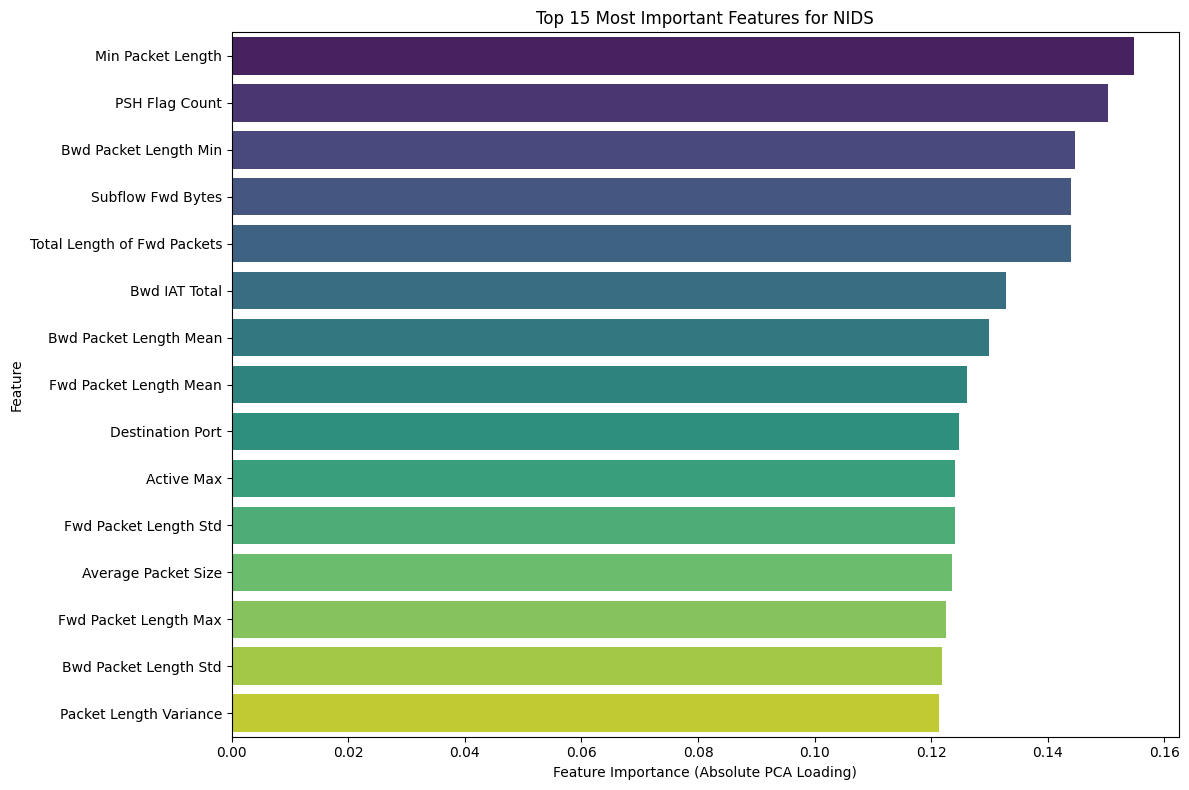


Evaluating classification performance with PCA components...
Classification Report:
                precision    recall  f1-score   support

          Bots       0.83      0.65      0.73       389
   Brute Force       1.00      1.00      1.00      1830
          DDoS       1.00      1.00      1.00     25603
           DoS       1.00      1.00      1.00     38749
Normal Traffic       1.00      1.00      1.00    419012
 Port Scanning       0.99      0.99      0.99     18139
   Web Attacks       0.99      0.97      0.98       429

      accuracy                           1.00    504151
     macro avg       0.97      0.94      0.96    504151
  weighted avg       1.00      1.00      1.00    504151



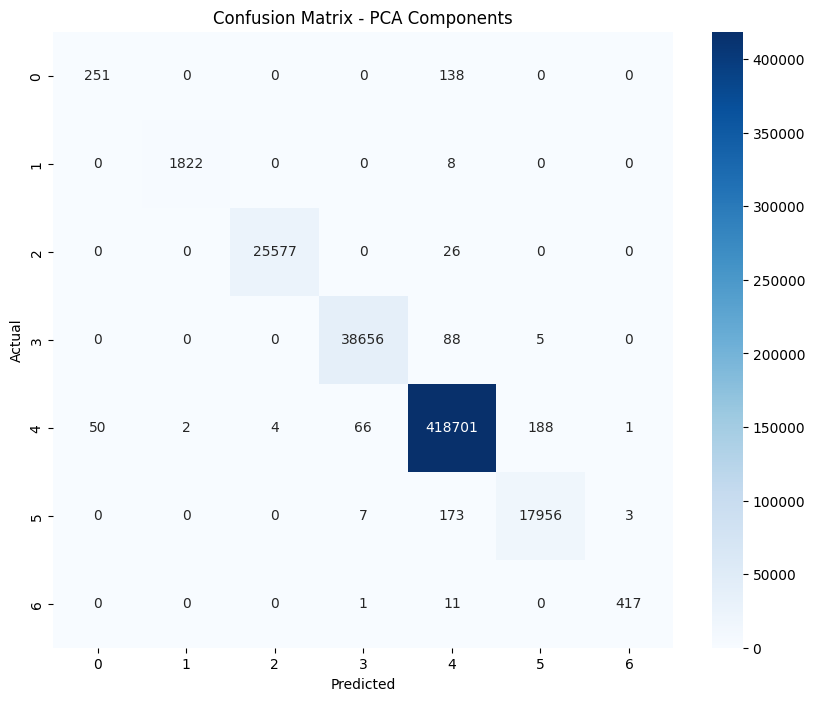

Classification accuracy using PCA components: 0.9985

Recommended features for your NIDS based on PCA analysis:
1. Min Packet Length
2. PSH Flag Count
3. Bwd Packet Length Min
4. Subflow Fwd Bytes
5. Total Length of Fwd Packets
6. Bwd IAT Total
7. Bwd Packet Length Mean
8. Fwd Packet Length Mean
9. Destination Port
10. Active Max
11. Fwd Packet Length Std
12. Average Packet Size
13. Fwd Packet Length Max
14. Bwd Packet Length Std
15. Packet Length Variance
16. Active Mean
17. Bwd Packet Length Max
18. Packet Length Mean
19. Packet Length Std
20. ACK Flag Count

Feature importance results saved to 'feature_importance_results.csv'

Total variance explained by first 20 components: 0.9508


In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import gdown
import os

class NIDS_PCA_Analyzer:
    def __init__(self, n_components=None):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        self.feature_names = []
        self.explained_variance_ratio_ = None

    def load_and_preprocess_data(self, file_path):
        """
        Load and preprocess the NIDS dataset
        """
        # Load dataset
        df = pd.read_csv(file_path)

        # Separate features and target
        X = df.drop('Attack Type', axis=1)
        y = df['Attack Type']

        # Store feature names
        self.feature_names = X.columns.tolist()

        # Handle missing values
        X = X.fillna(X.mean())

        return X, y

    def fit_pca(self, X):
        """
        Fit PCA on the standardized data
        """
        # Standardize the features
        X_scaled = self.scaler.fit_transform(X)

        # Fit PCA
        X_pca = self.pca.fit_transform(X_scaled)

        self.explained_variance_ratio_ = self.pca.explained_variance_ratio_

        return X_pca

    def determine_optimal_components(self, variance_threshold=0.95):
        """
        Determine the optimal number of components to explain desired variance
        """
        cumulative_variance = np.cumsum(self.explained_variance_ratio_)
        optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

        print(f"Optimal number of components to explain {variance_threshold*100}% variance: {optimal_components}")
        return optimal_components

    def plot_variance_explained(self):
        """
        Plot the explained variance ratio
        """
        plt.figure(figsize=(12, 6))

        # Individual explained variance
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(self.explained_variance_ratio_) + 1),
                self.explained_variance_ratio_)
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Individual Explained Variance')

        # Cumulative explained variance
        plt.subplot(1, 2, 2)
        cumulative_variance = np.cumsum(self.explained_variance_ratio_)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def get_feature_importance(self, n_features=10):
        """
        Get the most important features based on PCA loadings
        """
        # Get absolute loadings for first few components
        loadings = np.abs(self.pca.components_[:5, :])  # First 5 components
        feature_importance = np.mean(loadings, axis=0)

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': feature_importance
        })

        # Sort by importance
        importance_df = importance_df.sort_values('Importance', ascending=False)

        print(f"\nTop {n_features} Most Important Features:")
        print(importance_df.head(n_features))

        return importance_df

    def plot_feature_importance(self, n_features=15):
        """
        Plot the most important features
        """
        importance_df = self.get_feature_importance(n_features)

        plt.figure(figsize=(12, 8))
        sns.barplot(data=importance_df.head(n_features),
                   x='Importance', y='Feature', palette='viridis')
        plt.title(f'Top {n_features} Most Important Features for NIDS')
        plt.xlabel('Feature Importance (Absolute PCA Loading)')
        plt.tight_layout()
        plt.show()

    def evaluate_pca_performance(self, X, y, test_size=0.2):
        """
        Evaluate how well PCA components can classify attacks
        """
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Standardize and apply PCA
        X_train_scaled = self.scaler.transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        X_train_pca = self.pca.transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)

        # Train a classifier on PCA components
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = rf_classifier.predict(X_test_pca)

        # Evaluate performance
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix - PCA Components')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        return rf_classifier.score(X_test_pca, y_test)


def download_file_from_google_drive(file_id, output_path):
    """
    Download file from Google Drive using gdown
    """
    # Create the download URL
    url = f'https://drive.google.com/uc?id={file_id}'

    # Download the file
    gdown.download(url, output_path, quiet=False)

    print(f"File downloaded to: {output_path}")


def main():
    """
    Main function to run the PCA analysis for NIDS
    """
    # Google Drive file ID (extracted from the URL)
    file_id = '1aZYqdwk5dT4kSOStpVfUykmEqE4Pyuvd'
    local_file_path = 'cicids2017_cleaned.csv'

    # Check if file already exists
    if not os.path.exists(local_file_path):
        print("Downloading dataset from Google Drive...")
        download_file_from_google_drive(file_id, local_file_path)
    else:
        print("Using existing dataset file...")

    # Initialize the PCA analyzer
    nids_analyzer = NIDS_PCA_Analyzer()

    # Load actual data
    print("\nLoading and preprocessing data...")
    X, y = nids_analyzer.load_and_preprocess_data(local_file_path)

    print(f"Dataset shape: {X.shape}")
    print(f"Number of features: {len(nids_analyzer.feature_names)}")
    print(f"Target classes: {y.unique()}")
    print(f"Target distribution:\n{y.value_counts()}")

    # Fit PCA
    print("\nFitting PCA...")
    X_pca = nids_analyzer.fit_pca(X)

    # Determine optimal components
    optimal_components = nids_analyzer.determine_optimal_components()

    # Plot variance explained
    nids_analyzer.plot_variance_explained()

    # Get feature importance
    importance_df = nids_analyzer.get_feature_importance(15)

    # Plot feature importance
    nids_analyzer.plot_feature_importance(15)

    # Evaluate performance
    print("\nEvaluating classification performance with PCA components...")
    accuracy = nids_analyzer.evaluate_pca_performance(X, y)
    print(f"Classification accuracy using PCA components: {accuracy:.4f}")

    # Create reduced feature set
    print("\n" + "="*60)
    print("Recommended features for your NIDS based on PCA analysis:")
    print("="*60)
    top_features = importance_df.head(optimal_components)['Feature'].tolist()
    for i, feature in enumerate(top_features, 1):
        print(f"{i}. {feature}")

    # Optional: Save the results to a file
    importance_df.to_csv('feature_importance_results.csv', index=False)
    print("\nFeature importance results saved to 'feature_importance_results.csv'")

    # Optional: Show PCA component statistics
    print(f"\nTotal variance explained by first {optimal_components} components: "
          f"{np.sum(nids_analyzer.explained_variance_ratio_[:optimal_components]):.4f}")


if __name__ == "__main__":
    main()